# User defined solver

In this tutorial we want to show you how to use all of the infrastructure provided by **HQS Spectrum Tools**, but write your own customized solver. This specifically means that we enable you to use all options defined in `NMRParameters`, `NMRCalculationParameters` and `NMRSolverSettings` with the spin dependent clustering approach and only change the solver backend to evaluate the clusters.

Let's start as usual by importing all modules we are going to need:

In [1]:
# NMR
from hqs_nmr_parameters import read_parameters_yaml

from hqs_nmr.calculate import calculate_spectrum
from hqs_nmr.datatypes import NMRSolverSettings, NMRCalculationParameters
from hqs_nmr.solver import register_frequency_solver, NMR_FREQUENCY_SOLVERS
from hqs_nmr.solver.solver import NMRSolver
from hqs_nmr.solver.implementations.nmr_solver import nmr_solver

from struqture_py.spins import PauliHamiltonian

# external modules
import matplotlib.pyplot as plt
import numpy as np
from typing import Any

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

# License check turned off.
/home/jkleinebuening/micromamba/envs/hqs-nmr/lib/python3.13/site-packages/hqs_nmr/solver/implementations/complete_solver.py:15: PerformanceWarning: Computation uses more threads than physical cores. Consider setting the OMP_NUM_THREADS environment variable to the number of physical cores: `export OMP_NUM_THREADS=12`.
  from hqs_quantum_solver.spins import (


And again import the NMR parameters of propane as an example molecule:

In [2]:
molecule = read_parameters_yaml("propane.yaml")
molecule_parameters = molecule.spin_system()

For reference we also evaluate the spectrum with the default parameters and a spectrometer frequency of 500 MHz, which corresponds to a magnetic field of 11.7433 T:

In [3]:
calculation_parameters = NMRCalculationParameters(field_T=11.7433)
reference_result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
reference_spectrum = reference_result_spectrum.spectrum

With the reference spectrum at hand, we will now show you how to add your own solver to the existing ones. To add a solver, it has to follow the `NMRSolver` protocol. We will make it easy for ourselves and just write down the signature the solver function must have, but call the existing `nmr_solver` for the actual calculation. If you want to implement your own solver it is advisable to check out the `hamiltonian_tools` and `solver` modules of the `hqs_nmr` package. They contain a variety of functions to help you define your own solver.

In [4]:
def custom_solver(
    hamiltonian: PauliHamiltonian,
    normalized_gyromagnetic_ratios: np.ndarray,
    omegas: np.ndarray,
    eta: float,
    spin_contribution_indices: list[int],
    calculation_parameters: NMRCalculationParameters,
    **kwargs: dict[str, Any],  # noqa: ARG001
) -> np.ndarray:
    r"""Calculate an NMR spectrum exploiting Sz conservation given a PauliHamiltonian.

    Args:
        hamiltonian: Struqture spin Hamiltonian.
        normalized_gyromagnetic_ratios: Array of the gyromagnetic factors per site, normalized with
            respect to the reference isotope.
        omegas: Desired frequencies.
        eta: Explicit broadening of the peaks.
        spin_contribution_indices: List of indices l of I^+_l for which to evaluate the correlator.
        calculation_parameters: Object storing all calculation parameters including solver-specific
            settings.
        kwargs: Catch all for general interface.

    Returns:
        An array of the spectral function for the specified spin contributions at each
        frequency.

    Raises:
        ValueError: if number of spins does not match the number
            of gyromagnetic factors.
    """
    return nmr_solver(
        hamiltonian,
        normalized_gyromagnetic_ratios,
        omegas,
        eta,
        spin_contribution_indices,
        calculation_parameters,
    )

To check if our newly defined solver can actually be used within the `calculate_spectrum` function, we can check if it follows the `NMRSolver` protocol:

In [5]:
isinstance(custom_solver, NMRSolver)

True

With the solver specified we can now add it to the dictionary `NMR_FREQUENCY_SOLVERS` containing all implemented solvers. Note that you can only register a solver once, so if you try to run the next code cell twice without restarting you will get an error.

In [6]:
register_frequency_solver("custom_solver", custom_solver)
NMR_FREQUENCY_SOLVERS.keys()

dict_keys(['nmr_solver', 'nmr_solver_local_su2', 'reference_nmr_solver', 'complete_nmr_solver', 'custom_solver'])

Now we want to ensure, that our solver is actually used for the calculation. For this, we have to define the `solver_str` attribute of the `NMRSolverSettings` dataclass.

In [7]:
solver_settings = NMRSolverSettings(solver_str="custom_solver")

And with this, we are already done. We can now evaluate the spectrum using the `calculate_spectrum` function. It will internally create the spin Hamiltonian, cluster the molecule if necessary and evaluate each cluster using our just defined custom solver.

In [8]:
calculation_parameters = NMRCalculationParameters(field_T=11.7433, solver_settings=solver_settings)
custom_result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
custom_spectrum = custom_result_spectrum.spectrum

Finally, if we plot the result against the previously calculated reference spectrum, we see that we get indeed the same spectrum:

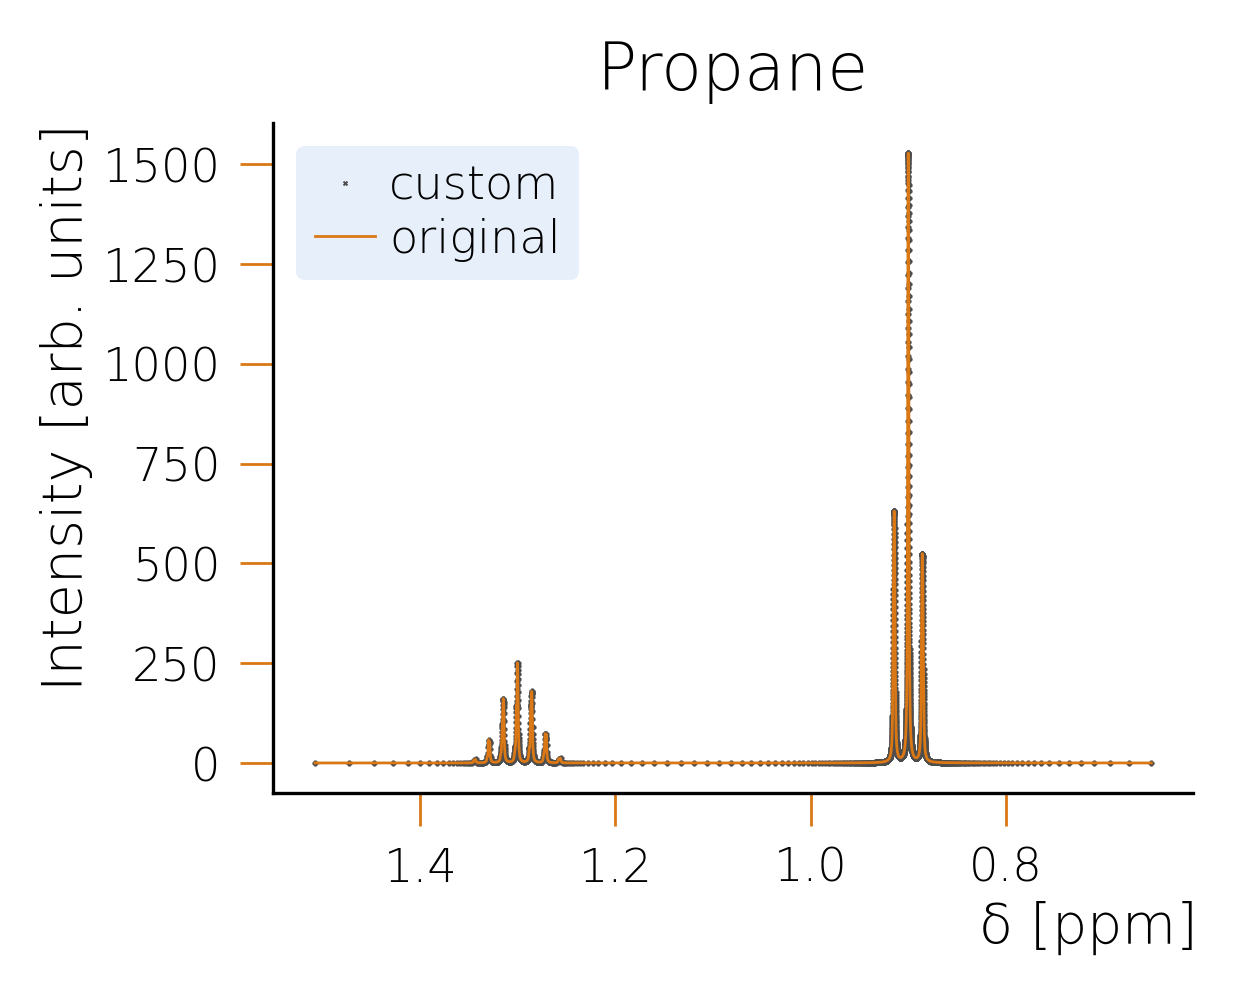

In [9]:
plt.plot(
    custom_spectrum.omegas_ppm,
    np.sum(custom_spectrum.spin_contributions, axis=0),
    "x",
    label="custom",
    markersize=0.5,
)
plt.plot(
    reference_spectrum.omegas_ppm,
    np.sum(reference_spectrum.spin_contributions, axis=0),
    label="original",
    linewidth=0.5,
)
plt.title("Propane")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.legend()
plt.gca().invert_xaxis()
plt.show()